In [1]:
#!pip install spaudiopy

## SWF

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from trimesh import Trimesh
from swf import SWF
from constants import vertices704, faces704,vertices301, faces301  
from utils import *

Calculating gains for 361 angles...


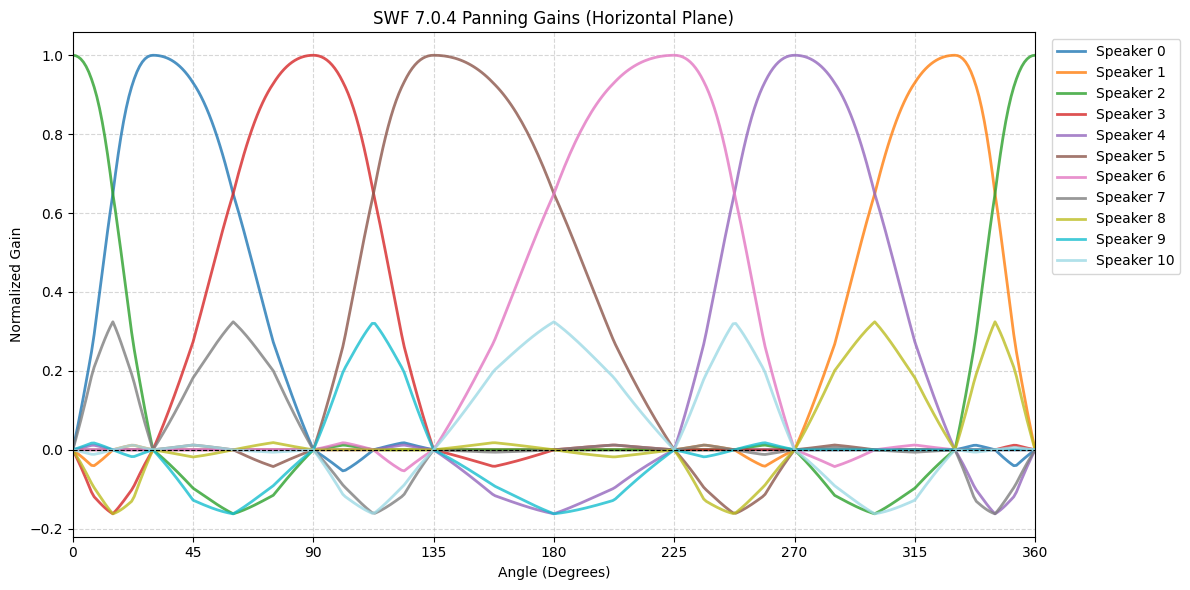

In [3]:

# 1. Initialize System
base_mesh = Trimesh(vertices=vertices704, faces=faces704)
swf = SWF(base_mesh, n=2)

# 2. Prepare calculation points (0 to 360 degrees)
angles = np.arange(0, 361, 1) 
gains_history = []

print(f"Calculating gains for {len(angles)} angles...")

# 3. Calculation Loop
for deg in angles:
    # A. Convert angle to vector (Horizontal plane z=0)
    theta = np.deg2rad(deg)
    target_vector = np.array([np.cos(np.deg2rad(0))*np.cos(theta),
                              np.cos(np.deg2rad(0))*np.sin(theta), 
                              np.sin(np.deg2rad(0))])
    
    # B. SWF Core Operations
    # Interpolate on fine mesh
    fine_signal = swf.interpolate(target_vector)
    
    # Encode to coarse gains
    raw_gains = swf.encode(fine_signal)
    
    # C. Energy Normalization
    energy = np.sum(raw_gains**2)
    final_gains = raw_gains / np.sqrt(energy)
        
    gains_history.append(final_gains.flatten())

gains_data = np.array(gains_history)

num_speakers = gains_data.shape[1]
colors = plt.cm.tab20(np.linspace(0, 1, num_speakers))

# 4. Plotting
plt.figure(figsize=(12, 6))

for i in range(num_speakers):
    plt.plot(angles, gains_data[:, i], 
             label=f'Speaker {i}', 
             color=colors[i], 
             linewidth=2, 
             alpha=0.8)

# Basic chart styling
plt.title('SWF 7.0.4 Panning Gains (Horizontal Plane)')
plt.xlabel('Angle (Degrees)')
plt.ylabel('Normalized Gain')
plt.xlim(0, 360)

# Set x-ticks every 45 degrees for readability
plt.xticks(np.arange(0, 361, 45))

# Zero gain reference line
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

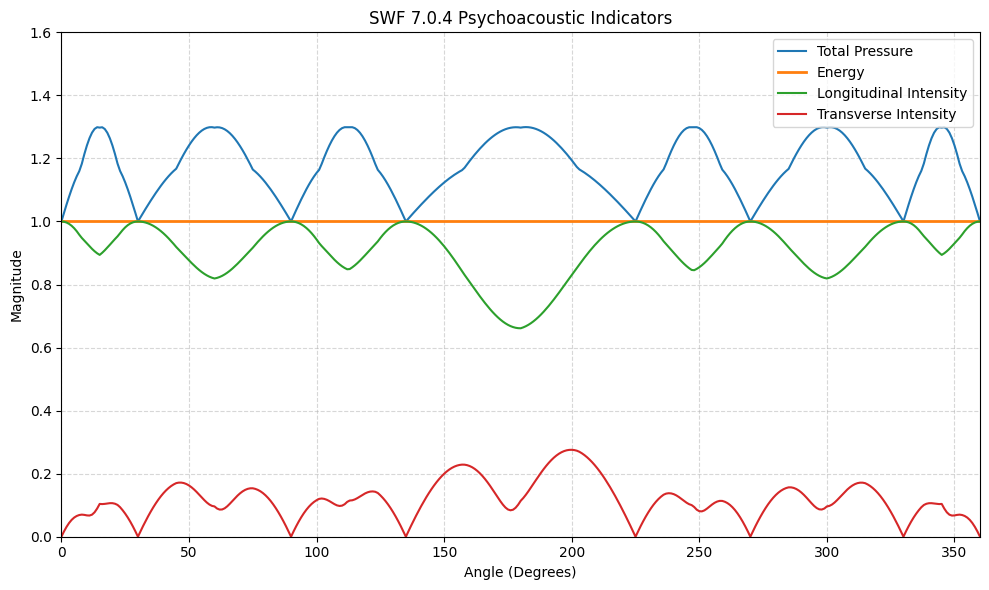

In [4]:
angles = np.arange(0, 361, 1) 
hist_pressure = []; hist_energy = []; hist_Il = []; hist_It = []

for deg in angles:
    # 1. Target Vector (Horizontal)
    theta = np.deg2rad(deg)
    target_vector = np.array([np.cos(np.deg2rad(0))*np.cos(theta),
                              np.cos(np.deg2rad(0))*np.sin(theta), 
                              np.sin(np.deg2rad(0))])
    
    # 2. SWF Calculation
    fine = swf.interpolate(target_vector)
    raw = swf.encode(fine)
    
    # 3. Normalize Energy
    e_val = np.sum(raw**2)
    final_gains = raw / np.sqrt(e_val) if e_val > 1e-9 else raw
    
    # 4. Calculate Indicators
    p = np.sum(final_gains)
    
    eng = np.sum(np.absolute(final_gains)**2)
    
    Il, It = intensity(final_gains, swf.base.vertices, target_vector)
    
    hist_pressure.append(p)
    hist_energy.append(eng)
    hist_Il.append(Il)
    hist_It.append(It)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(angles, hist_pressure, label='Total Pressure', color='tab:blue')
plt.plot(angles, hist_energy, label='Energy', color='tab:orange', linewidth=2)
plt.plot(angles, hist_Il, label='Longitudinal Intensity', color='tab:green')
plt.plot(angles, hist_It, label='Transverse Intensity', color='tab:red')

plt.title('SWF 7.0.4 Psychoacoustic Indicators')
plt.xlabel('Angle (Degrees)')
plt.ylabel('Magnitude')
plt.xlim(0, 360)
plt.ylim(0, 1.6)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Ambisonics

In [5]:
import spaudiopy as spa

In [6]:
# Loudspeaker Setup
ls_dirs = np.array([[30,-30,0,90,-90,135,-135,45,-45,135,-135],
                    [0,0,0,0,0,0,0,45,45,45,45]])
ls_x, ls_y, ls_z = spa.utils.sph2cart(spa.utils.deg2rad(ls_dirs[0, :]),
                                      spa.utils.deg2rad(90-ls_dirs[1, :]))
ls_setup = spa.decoder.LoudspeakerSetup(ls_x, ls_y, ls_z)
ls_setup.pop_triangles(normal_limit=85, aperture_limit=90,
                       opening_limit=150)
ls_setup.ambisonics_setup(update_hull=True)

# If the azimuth degree of target is 30
target_azi_deg = 30  
target_elev_deg = 0  


src_azi = np.deg2rad(target_azi_deg)
src_zen = np.deg2rad(90 - target_elev_deg) # Zenith = 90 - Elev

order = 3
Y_source = spa.sph.sh_matrix(order, src_azi, src_zen, sh_type='real')

decoder_matrix = spa.decoder.allrad(np.eye(16),ls_setup,3,1)







gains = decoder_matrix @ Y_source.T
gains 

Face not pointing towards listener: [1 6 4]
Face not pointing towards listener: [0 1 2]
Face not pointing towards listener: [0 1 3]
Face not pointing towards listener: [1 6 5]
Face not pointing towards listener: [1 3 5]


array([[ 0.71276068],
       [ 0.04886678],
       [ 0.47685502],
       [ 0.31067488],
       [-0.0111481 ],
       [-0.01876123],
       [ 0.00483604],
       [ 0.36122001],
       [ 0.04984438],
       [-0.01464105],
       [ 0.01259343]])

In [7]:
order = 3
num_speakers = 11

# Loudspeaker Setup
ls_dirs = np.array([[30,-30,0,90,-90,135,-135,45,-45,135,-135],
                    [0,0,0,0,0,0,0,45,45,45,45]])
ls_x, ls_y, ls_z = spa.utils.sph2cart(spa.utils.deg2rad(ls_dirs[0, :]),
                                      spa.utils.deg2rad(90-ls_dirs[1, :]))

ls_setup = spa.decoder.LoudspeakerSetup(ls_x, ls_y, ls_z)
ls_setup.pop_triangles(normal_limit=85, aperture_limit=90,
                       opening_limit=150)
ls_setup.ambisonics_setup(update_hull=True)

decoder_matrix = spa.decoder.allrad(np.eye(16),ls_setup,order,1)

gains_history = []

# If the azimuth degree of target is 30  
target_elev_deg = 0  
src_zen = np.deg2rad(90 - target_elev_deg) # Zenith = 90 - Elev

azimuths = np.arange(0, 361, 1) 
src_azi = np.deg2rad(azimuths)
for degree in src_azi:

    Y_source = spa.sph.sh_matrix(order, degree, src_zen, sh_type='real')

    # Calculate the gain of each speaker
    gains = decoder_matrix @ Y_source.T
    gains_history.append(gains)

gains_history = np.array(gains_history).squeeze()
gains_history.shape
 

Face not pointing towards listener: [1 6 4]
Face not pointing towards listener: [0 1 2]
Face not pointing towards listener: [0 1 3]
Face not pointing towards listener: [1 6 5]
Face not pointing towards listener: [1 3 5]


(361, 11)

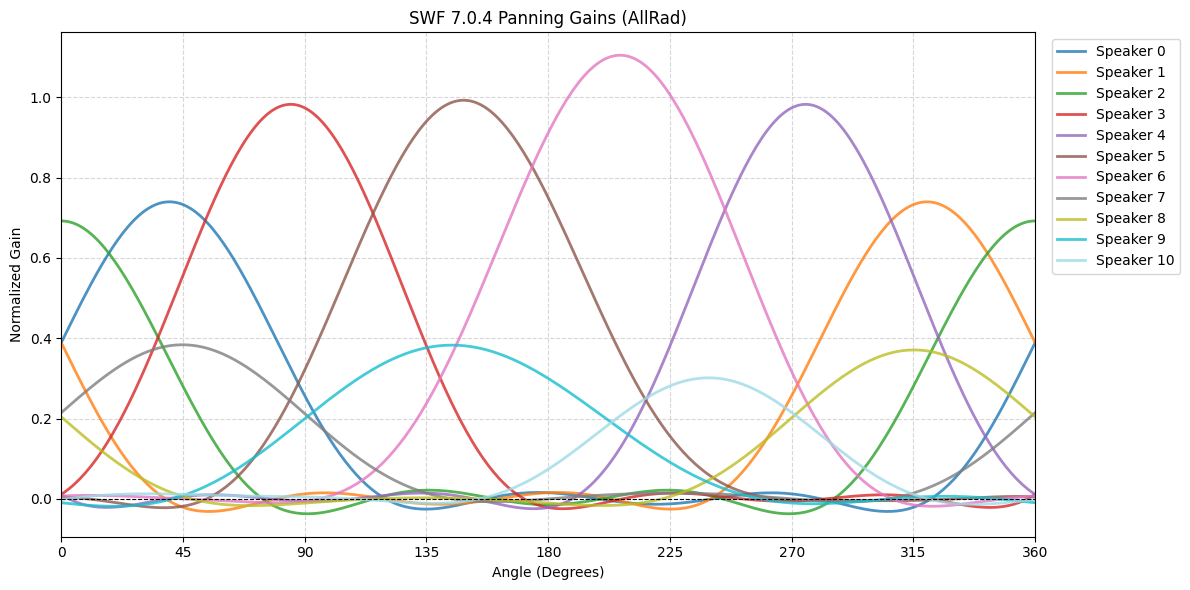

In [8]:
# Plotting
plt.figure(figsize=(12, 6))

for i in range(num_speakers):
    plt.plot(azimuths, gains_history[:, i], 
             label=f'Speaker {i}', 
             color=colors[i], 
             linewidth=2, 
             alpha=0.8)

# Basic chart styling
plt.title('SWF 7.0.4 Panning Gains (AllRad)')
plt.xlabel('Angle (Degrees)')
plt.ylabel('Normalized Gain')
plt.xlim(0, 360)

# Set x-ticks every 45 degrees for readability
plt.xticks(np.arange(0, 361, 45))

# Zero gain reference line
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

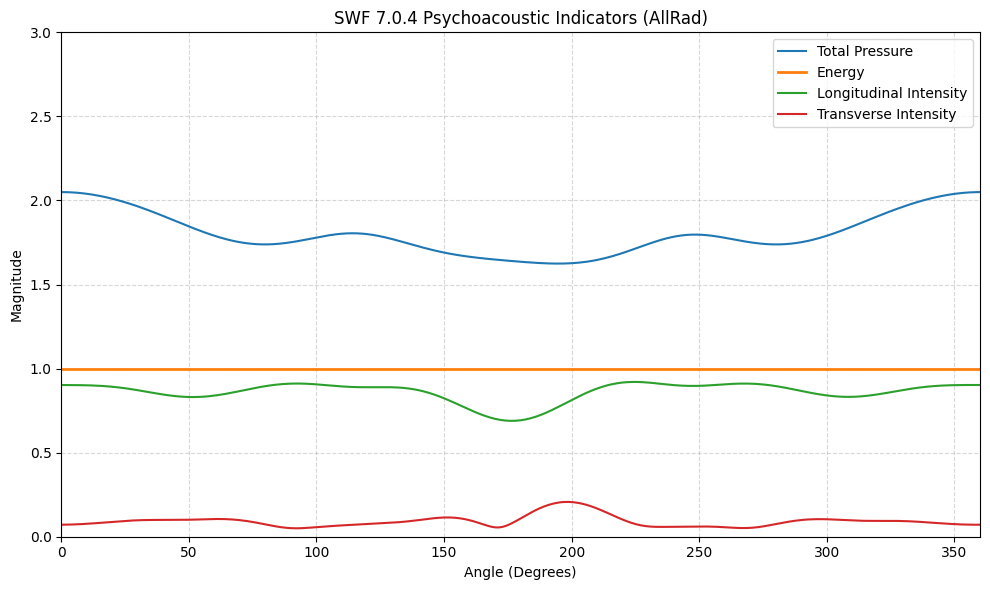

In [9]:
hist_pressure = []; hist_energy = []; hist_Il = []; hist_It = []
azimuths = np.arange(0, 361, 1) 
src_azi = np.deg2rad(azimuths)
for degree in src_azi:
    Y_source = spa.sph.sh_matrix(order, degree, src_zen, sh_type='real')
    t_vec = np.array([np.cos(np.deg2rad(0))*np.cos(degree),
                              np.cos(np.deg2rad(0))*np.sin(degree), 
                              np.sin(np.deg2rad(0))])
    # Calculate the gain of each speaker
    gains = decoder_matrix @ Y_source.T

    e_val = np.sum(gains**2)
    final_gains = gains / np.sqrt(e_val) if e_val > 1e-9 else gains

    # 4. Calculate Indicators
    p = np.sum(final_gains)
    eng = np.sum(np.absolute(final_gains)**2)
    speaker_powers = np.abs(final_gains)**2
    unit_vectors = np.array([ls_x, ls_y, ls_z]).T
    I = np.dot(speaker_powers.T, unit_vectors)
    Il = np.dot(I, t_vec)

    # Transverse Intensity (Cross Product)
    # Magnitude of the component perpendicular to the Target vector
    It = np.linalg.norm(np.cross(I, t_vec))

    
    hist_pressure.append(p)
    hist_energy.append(eng)
    hist_Il.append(Il)
    hist_It.append(It)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(angles, hist_pressure, label='Total Pressure', color='tab:blue')
plt.plot(angles, hist_energy, label='Energy', color='tab:orange', linewidth=2)
plt.plot(angles, hist_Il, label='Longitudinal Intensity', color='tab:green')
plt.plot(angles, hist_It, label='Transverse Intensity', color='tab:red')

plt.title('SWF 7.0.4 Psychoacoustic Indicators (AllRad)')
plt.xlabel('Angle (Degrees)')
plt.ylabel('Magnitude')
plt.xlim(0, 360)
plt.ylim(0, 3)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Face not pointing towards listener: [1 6 4]
Face not pointing towards listener: [0 1 2]
Face not pointing towards listener: [0 1 3]
Face not pointing towards listener: [1 6 5]
Face not pointing towards listener: [1 3 5]


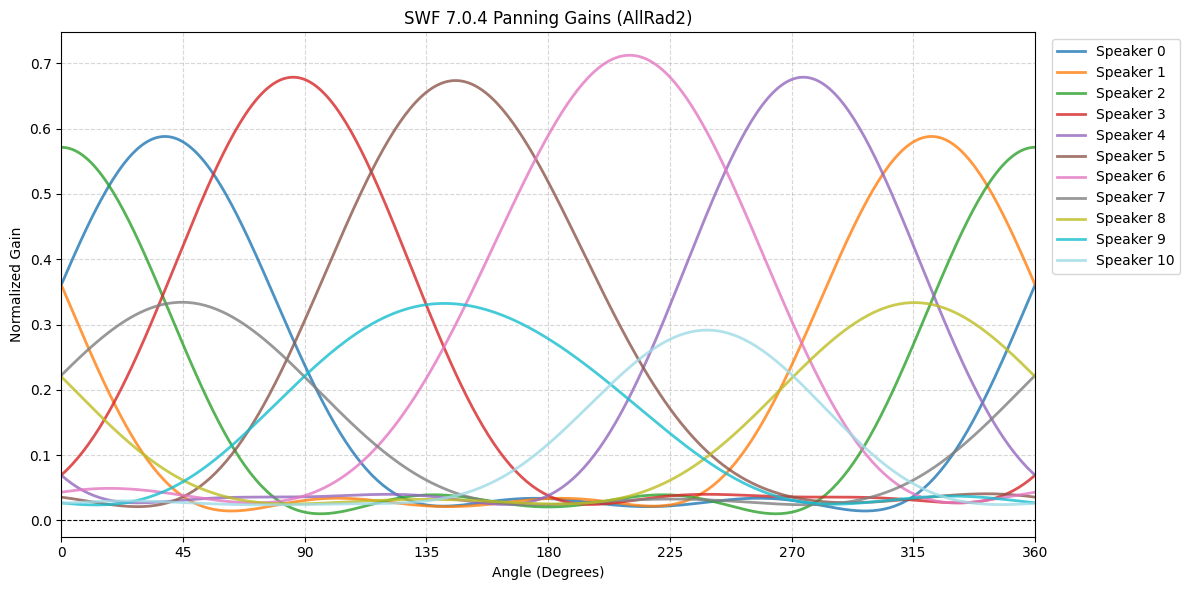

In [10]:
order = 3
num_speakers = 11

# Loudspeaker Setup
ls_dirs = np.array([[30,-30,0,90,-90,135,-135,45,-45,135,-135],
                    [0,0,0,0,0,0,0,45,45,45,45]])
ls_x, ls_y, ls_z = spa.utils.sph2cart(spa.utils.deg2rad(ls_dirs[0, :]),
                                      spa.utils.deg2rad(90-ls_dirs[1, :]))
ls_setup = spa.decoder.LoudspeakerSetup(ls_x, ls_y, ls_z)
ls_setup.pop_triangles(normal_limit=85, aperture_limit=90,
                       opening_limit=150)
ls_setup.ambisonics_setup(update_hull=True)

decoder_matrix = spa.decoder.allrad2(np.eye(16),ls_setup,order)

gains_history = []

# If the azimuth degree of target is 30  
target_elev_deg = 0  
src_zen = np.deg2rad(90 - target_elev_deg) # Zenith = 90 - Elev

azimuths = np.arange(0, 361, 1) 
src_azi = np.deg2rad(azimuths)
for degree in src_azi:

    Y_source = spa.sph.sh_matrix(order, degree, src_zen, sh_type='real')

    # Calculate the gain of each speaker
    gains = decoder_matrix @ Y_source.T
    gains_history.append(gains)

gains_history = np.array(gains_history).squeeze()

# Plotting
plt.figure(figsize=(12, 6))

for i in range(num_speakers):
    plt.plot(azimuths, gains_history[:, i], 
             label=f'Speaker {i}', 
             color=colors[i], 
             linewidth=2, 
             alpha=0.8)

# Basic chart styling
plt.title('SWF 7.0.4 Panning Gains (AllRad2)')
plt.xlabel('Angle (Degrees)')
plt.ylabel('Normalized Gain')
plt.xlim(0, 360)

# Set x-ticks every 45 degrees for readability
plt.xticks(np.arange(0, 361, 45))

# Zero gain reference line
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()
 

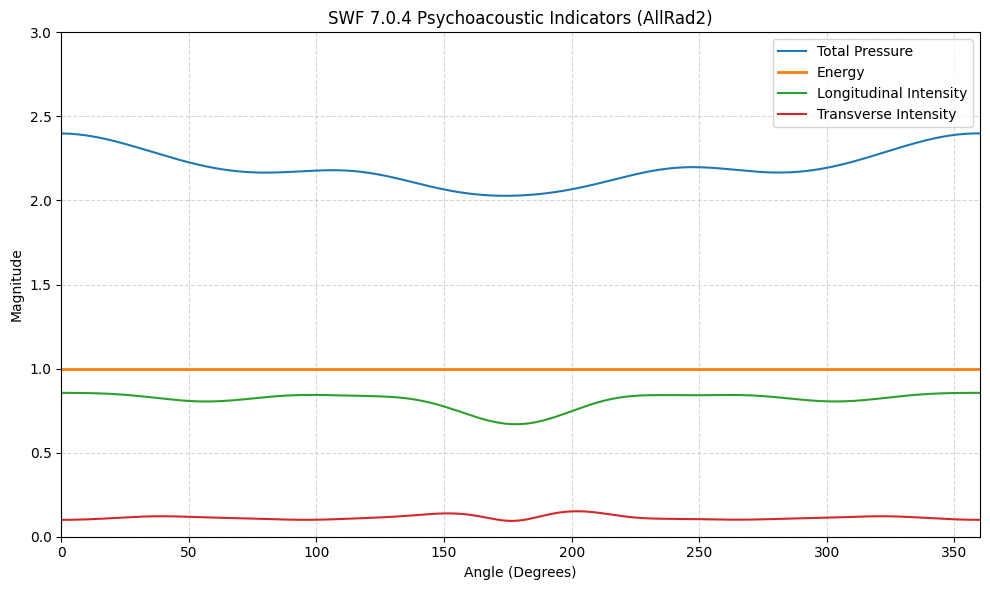

In [11]:
hist_pressure = []; hist_energy = []; hist_Il = []; hist_It = []
azimuths = np.arange(0, 361, 1) 
src_azi = np.deg2rad(azimuths)
for degree in src_azi:
    Y_source = spa.sph.sh_matrix(order, degree, src_zen, sh_type='real')
    t_vec = np.array([np.cos(np.deg2rad(0))*np.cos(degree),
                              np.cos(np.deg2rad(0))*np.sin(degree), 
                              np.sin(np.deg2rad(0))])
    # Calculate the gain of each speaker
    gains = decoder_matrix @ Y_source.T

    e_val = np.sum(gains**2)
    final_gains = gains / np.sqrt(e_val) if e_val > 1e-9 else gains

    # 4. Calculate Indicators
    p = np.sum(final_gains)
    eng = np.sum(np.absolute(final_gains)**2)
    speaker_powers = np.abs(final_gains)**2
    unit_vectors = np.array([ls_x, ls_y, ls_z]).T
    I = np.dot(speaker_powers.T, unit_vectors)
    Il = np.dot(I, t_vec)

    # Transverse Intensity (Cross Product)
    # Magnitude of the component perpendicular to the Target vector
    It = np.linalg.norm(np.cross(I, t_vec))

    
    hist_pressure.append(p)
    hist_energy.append(eng)
    hist_Il.append(Il)
    hist_It.append(It)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(angles, hist_pressure, label='Total Pressure', color='tab:blue')
plt.plot(angles, hist_energy, label='Energy', color='tab:orange', linewidth=2)
plt.plot(angles, hist_Il, label='Longitudinal Intensity', color='tab:green')
plt.plot(angles, hist_It, label='Transverse Intensity', color='tab:red')

plt.title('SWF 7.0.4 Psychoacoustic Indicators (AllRad2)')
plt.xlabel('Angle (Degrees)')
plt.ylabel('Magnitude')
plt.xlim(0, 360)
plt.ylim(0, 3)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()